In [2]:
import numpy as np
import pandas as pd

In [3]:
from keras.datasets import mnist
(X_train, y_train), (X_test, y_test) = mnist.load_data()

Using TensorFlow backend.


In [4]:
print(X_train.shape) # (60000, 28, 28)
print(X_test.shape) # (10000, 28, 28)
print(X_train[0].dtype) # uint8

(60000, 28, 28)
(10000, 28, 28)
uint8


In [5]:
X_train = X_train.reshape((60000, 1, 28, 28))
X_test = X_test.reshape((10000, 1, 28, 28))

In [6]:
print(X_train.shape)
print(X_test.shape)

(60000, 1, 28, 28)
(10000, 1, 28, 28)


In [7]:
X_train[0:5].shape

(5, 1, 28, 28)

In [8]:
X_train = X_train.astype(np.float)
X_test = X_test.astype(np.float)
X_train /= 255
X_test /= 255
print(X_train.max()) # 1.0
print(X_train.min()) # 0.0

1.0
0.0


In [9]:
from sklearn.preprocessing import OneHotEncoder
enc = OneHotEncoder(handle_unknown='ignore', sparse=False)
y_train_one_hot = enc.fit_transform(y_train[:, np.newaxis])
y_test_one_hot = enc.transform(y_test[:, np.newaxis])
print(y_train.shape) # (60000,)
print(y_train_one_hot.shape) # (60000, 10)
print(y_train_one_hot.dtype) # float64

(60000,)
(60000, 10)
float64


In [10]:
from sklearn.model_selection import train_test_split

In [11]:
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train_one_hot, test_size=0.2)

In [12]:
print(X_train.shape)
print(X_val.shape)
print(y_train.shape)
print(y_val.shape)

(48000, 1, 28, 28)
(12000, 1, 28, 28)
(48000, 10)
(12000, 10)


### 【問題1】2次元畳み込み層の作成
1次元畳み込み層のクラスConv1dを発展させ、2次元畳み込み層のクラスConv2dを作成してください。

### 【問題2】2次元畳み込み後の出力サイズ
畳み込みを行うと特徴マップのサイズが変化します。どのように変化するかは以下の数式から求められます。この計算を行う関数を作成してください。

### 【問題3】最大プーリング層の作成
最大プーリング層のクラスMaxPool2Dを作成してください。  

In [70]:
        #  Sammary  Forward
        #  -----------------------------------------------------------------------------------------------------------------
        #  Layer (type)                       Input Shape                     Filter Shape             Output Shape   
        #  ================================================================
        #  conv2d_1 (Conv2D)       (sample, 1, 28, 28)         ( 32,1, 2, 2)         (sample, 32, 26, 26)     
        #  ________________________________________________________________
        #  maxpooling2d_1 
        #  (MaxPooling2D)             (sample, 32, 26, 26)            ( 2, 2)                (sample, 32, 13, 13)
        #  ________________________________________________________________
        #  conv2d_2 (Conv2D)    (sample, 32, 13, 13)        (64, 32, 2, 2)       (sample, 64, 11, 11)
        #  ________________________________________________________________
        #  maxpooling2d_2 
        #  (MaxPooling2D)            (sample, 64, 11, 11)           ( 2, 2)                (sample, 64, 5, 5)
        #  ________________________________________________________________
        #  conv2d_3 (Conv2D)    (sample, 64, 5, 5)         ( 64, 64, 2, 2)          (sample,64,  3, 3)                                                    
        #  ________________________________________________________________
        #  flatten_1 (Flatten)      (sample,64,  3, 3)                                              (sample, 576)
        #  ________________________________________________________________
        #  dense_1 (Dense)          (sample, 576)                                                     (sample, 64)
        #  ________________________________________________________________
        #  dense_2 (Dense)         (sample, 64)                                                        (sample, 10)
        #  ================================================================                                                                                                    

In [71]:
from sklearn.metrics import accuracy_score

In [72]:
class GetMiniBatch():
    """
    ミニバッチを取得するイテレータ

    Parameters
    ----------
    X : 次の形のndarray, shape (n_samples, n_features)
      訓練データ
    y : 次の形のndarray, shape (n_samples, 1)
      正解値
    batch_size : int
      バッチサイズ
    seed : int
      NumPyの乱数のシード
    """
    def __init__(self, X, y, batch_size = 20, seed=0):
        self.batch_size = batch_size
        np.random.seed(seed)
        shuffle_index = np.random.permutation(np.arange(X.shape[0]))
        self._X = X[shuffle_index]
        self._y = y[shuffle_index]
        self._stop = np.ceil(X.shape[0]/self.batch_size).astype(np.int)
    def __len__(self):
        return self._stop
    def __getitem__(self,item):
        p0 = item*self.batch_size
        p1 = item*self.batch_size + self.batch_size
        return self._X[p0:p1], self._y[p0:p1]        
    def __iter__(self):
        self._counter = 0
        return self
    def __next__(self):
        if self._counter >= self._stop:
            raise StopIteration()
        p0 = self._counter*self.batch_size
        p1 = self._counter*self.batch_size + self.batch_size
        self._counter += 1
        return self._X[p0:p1], self._y[p0:p1]

In [73]:
class He:
    """
    ガウス分布によるシンプルな初期化
    Parameters
    ----------
    sigma : float
      ガウス分布の標準偏差
    """
    def __init__(self, siguma):
        self.siguma = siguma
        
    def W(self, n_nodes1, n_nodes2):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        H_siguma = np.sqrt(2/n_nodes1)
        W = H_siguma*np.random.randn(n_nodes1, n_nodes2)

        return W
    def B(self, n_nodes2):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        H_siguma = np.sqrt(2/n_nodes2)
        B = H_siguma*np.random.randn(n_nodes2)
#         print('B'+str(B.shape))

        return B

    def filter(self, filter_info):
        """
        重みの初期化
        Parameters
        ----------
        n_nodes1 : int
          前の層のノード数
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        W :
        """
        filter_num, filter_chan, filter_row, filter_col = filter_info

        H_siguma = np.sqrt(2/filter_num)
        filter = H_siguma*np.random.randn(filter_num, filter_chan, filter_row, filter_col)
        
        return filter

    def bias(self,  filter_num):
        """
        バイアスの初期化
        Parameters
        ----------
        n_nodes2 : int
          後の層のノード数
        Returns
        ----------
        B :
        """
        H_siguma = np.sqrt(2/filter_num)
        bias = H_siguma*np.random.randn(filter_num)
#         print('bias' + str(bias.shape))

        return bias

In [74]:
class AdaGrad:
    """
    確率的勾配降下法
    Parameters
    ----------
    lr : 学習率
    """
    def __init__(self, lr, type = 'all_conect'):
        self.lr = lr
        self.type = type
        
    def update(self, layer):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
#         from (zerotuku)
#         for key in params.keys():
#             self.h[key] += grads[key] * grads[key]
#             params[key] -= self.lr * grads[key] / (np.sqrt(self.h[key]) + 1e-7)
#         print(layer.dW.shape)

        # 全結合層用
        if self.type == 'all_conect':
            layer.ada_W += layer.dW**2
            layer.ada_B += layer.dB**2

            layer.W -= self.lr*layer.dW/(np.sqrt(layer.ada_W) + 1e-7)
            layer.B -= (self.lr*layer.dB/(np.sqrt(layer.ada_B) + 1e-7)).mean(0)
#             print('layer.B'+ str(layer.B.shape))

        # コンボル層更新用
        if self.type == 'conv':
            layer.ada_filter += layer.dfilter**2
            layer.ada_bias += layer.dbias**2
            
#             j = (self.lr*layer.dbias/(np.sqrt(layer.ada_bias) + 1e-7))
#             print(j.shape)

# #             print用
            j = (self.lr*layer.dbias/(np.sqrt(layer.ada_bias) + 1e-7))
#             print('layer.bias_pre'+ str(j.shape))
            
            layer.filter -= self.lr*layer.dfilter/(np.sqrt(layer.ada_filter) + 1e-7)
            layer.bias -= (self.lr*layer.dbias/(np.sqrt(layer.ada_bias) + 1e-7)).mean(-1).mean(-1).mean(0)
#             print('layer.bias_pre'+ str(self.lr*layer.dbias/(np.sqrt(layer.ada_bias) + 1e-7)).mean(1).mean(1))

        return layer

In [75]:
class Relu:

    def __init__(self):
        self.mask = None
        
    def forward(self, X):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.mask = (X <= 0)
        out = X.copy()
        out[self.mask] = 0
 
        return out

    def backward(self, dout):
        dout[self.mask] = 0
        dX = dout

        return dout

In [76]:
class Softmax_with_Loss:
    
    def __init__(self,):
        self.forword_A = None
        
    def forward(self, A):
        """
        ある層の重みやバイアスの更新
        Parameters
        ----------
        layer : 更新前の層のインスタンス
        """
        self.forword_A = np.exp(A)/(np.exp(A).sum(1).reshape(-1, 1))
        return self.forword_A

    def backward(self, y):

        return self.forword_A - y

## Forword and Backword

In [77]:
class FC:
    """
    ノード数n_nodes1からn_nodes2への全結合層
    Parameters
    ----------
    n_nodes1 : int
      前の層のノード数
    n_nodes2 : int
      後の層のノード数
    initializer : 初期化方法のインスタンス
    optimizer : 最適化手法のインスタンス
    """
    def __init__(self, n_nodes1, n_nodes2, initializer, optimizer):
        self.optimizer = optimizer
        # 初期化
        # initializerのメソッドを使い、self.Wとself.Bを初期化する
        self.W = initializer.W(n_nodes1, n_nodes2)
        self.B = initializer.B(n_nodes2)
        self.dB = 0
        self.dW = 0
        self.ada_W = 0
        self.ada_B = 0
        self.v_W = 0
        self.v_B = 0
        
    def forward(self, X):
        """
        フォワード
        Parameters
        ----------
        X : 次の形のndarray, shape (batch_size, n_nodes1)
            入力
        Returns
        ----------
        A : 次の形のndarray, shape (batch_size, n_nodes2)
            出力
        """
        self.forward_Z = X.copy()
        A = np.dot(X, self.W) + self.B        
        
        return A
    def backward(self, dA):
        """
        バックワード
        Parameters
        ----------
        dA : 次の形のndarray, shape (batch_size, n_nodes2)
            後ろから流れてきた勾配
        Returns
        ----------
        dZ : 次の形のndarray, shape (batch_size, n_nodes1)
            前に流す勾配
        """

        self.dB = dA
        self.dW = np.dot(self.forward_Z.T, dA)
        dZ = np.dot(dA, self.W.T)
        # 更新
        
        self.optimizer.update(self)
        
        return dZ

In [78]:
class Conv2d:
    def __init__(self, filter_info, initializer, optimizer, shapetype = None):
        self.optimizer = optimizer
        self.filter_num, self.filter_kernel, self.filter_row, self.filter_col = filter_info
        self.shapetype = shapetype

        self.filter = initializer.filter(filter_info)
        self.bias = initializer.bias(self.filter_num)
        self.ada_filter = 0
        self.dfilter = 0
        self.ada_bias =0
        self.dbias = 0


        # filter = np.ones([self.filter_num, self.filter_row, self.filter_col, channel_num])
        # bias = np.ones([self.filter_num, 1, 1])
        # self.W = initializer.W(n_nodes1, n_nodes2)
        # self.B = initializer.B(n_nodes2)
    
    def forward( self, input):

        self.forward_input = input.copy()

        #最初だけ型が違うから。
        # if self.shapetype == 'first':
        #     print('first')
        #     sample_num, input_row, input_col, channel_num = input.shape
            
        
#         print('second')
        sample_num, input_channel, input_row, input_col = input.shape

        slide_row = input_row - self.filter_row
        slide_col = input_col - self.filter_col

        # if self.shapetype == 'first':
        #     #出力の形状設定
        #     out_put = np.zeros([sample_num, self.filter_num, slide_row, slide_col])
        #     for sample in range(sample_num):
        #         for filter_n in range(self.filter_num):
        #             for row in range(slide_row):
        #                 for col in range(slide_col):
        #                     a = (input[sample, row : row + self.filter_row, col : col + self.filter_col]*self.filter[filter_n]).sum() + self.bias[filter_n]
        #                     out_put[sample, filter_n, row, col] = a 
                        
    # else:
        #出力の形状設定
        out_put = np.zeros([sample_num, self.filter_num, slide_row, slide_col])
        for sample in range(sample_num):
            for input_chan in range(input_channel):
                for filter_n in range(self.filter_num):
                    for row in range(slide_row):
                        for col in range(slide_col):
                            a = (input[sample, input_chan, row : row + self.filter_row, col : col + self.filter_col]*self.filter[filter_n]).sum() + self.bias[filter_n]
                            out_put[sample, filter_n, row, col] = a
                        
        return out_put

    def backward(self, dA):
        
        self.dbias = dA
        dX = np.zeros(list(self.forward_input.shape))
        self.dfilter = np.zeros(list(self.filter.shape))

        sample_inp,chan_inp , row_inp, col_inp = self.forward_input.shape

        filter_num, filter_chan, filter_row, filter_col = self.filter.shape

        dAsample, dAchanel, dArow, dAcol = dA.shape
        # print(self.filter.shape)
        # print(filter_row, filter_col)

        for sample in range(dAsample):
            for i_chan in range(chan_inp):
                for chanel_n in range(dAchanel):
                    for row in range(dArow):
                        for col in range(dAcol):
                            # print(dX[sample, row:row+filter_row, col:col+filter_col])
                            # print(dA[sample, chanel_n, row, col]
                            # print(self.filter[chanel_n])
                            # print(dX[sample, row:row+filter_row, col:col+filter_col].shape)
                            # print(dA[sample, chanel_n, row, col].shape)
                            # print(self.filter[chanel_n].shape)

                            dX[sample,i_chan, row:row+filter_row, col:col+filter_col] += dA[sample, chanel_n, row, col]*self.filter[chanel_n, i_chan]
                            self.dfilter[chanel_n,i_chan] += dA[sample, chanel_n, row, col]*self.forward_input[sample, i_chan, row:row+filter_row, col:col+filter_col]

        self.optimizer.update(self)

        return dX

## Max_Pooling

In [79]:
class Max_Pooling:
    def __init__(self, shape = (2, 2)):
        self.filter_row, self.filter_col = shape
        self.max_index = 0
        
    def forward(self, X):
        # Max_pool
        # X.sahpe (5, 32, 3, 3)
        # (X_sample, filter_num, filter_row, filter_col)

        input_sample, input_fillnum, input_row, input_col = X.shape
        self.foward_X = X
#         print(input_row)
#         print(self.filter_row)

        if input_row%self.filter_row != 0:
            input_row = input_row - (input_row%self.filter_row)
            input_col = input_col - (input_col%self.filter_col)

        slide_row = int(input_row/self.filter_row)
        slide_col = int(input_col/self.filter_col)
        self.max_index = []

        out_put = np.zeros([input_sample, input_fillnum, slide_row, slide_col])

        for sample_n in range(input_sample):
            for filter_n in range(input_fillnum):
                for row in range(slide_row):
                    for col in range(slide_col):
                        
                        X_where = X[sample_n,  filter_n, (row*self.filter_row):(row*self.filter_row)+self.filter_row, (col*self.filter_col):(col*self.filter_col)+self.filter_col]
                        index = np.unravel_index(np.argmax(X_where, axis=None), X_where.shape)
                        X_max_index = [sample_n,  filter_n, (row*self.filter_row)+index[0], (col*self.filter_col)+index[1]]
#                         print('max_index{}'.format(np.array(index)))
                        self.max_index.append(X_max_index)
                        out_put[sample_n, filter_n, row, col] = X_where.max()
        
        return out_put
    
    def backward(self, A):
        # Max_pool　　back
#         (5, 32, 13, 13)から
#         元のshape(5, 32, 26, 26)へ戻す

        loss_sample, loss_fillnum, loss_row, loss_col = A.shape
        loss_1darray = A.ravel()
        foward_sample, foward_channel, foward_row, foward_col = self.foward_X.shape
        
#         new_row, new_col = loss_row*self.filter_row, loss_col*self.filter_col

        out_put = np.zeros([loss_sample, loss_fillnum, foward_row, foward_col])
#         print(len(self.max_index))

#         for sample_n in range(loss_sample):
#             for filter_n in range(loss_fillnum):
        for index in range(len(self.max_index)):
            index_row = self.max_index[index]
            out_put[index_row[0], index_row[1], index_row[2], index_row[3]] = loss_1darray[index]
                    
        return out_put

### 【問題5】平滑化
平滑化するためのFlattenクラスを作成してください。  
フォワードのときはチャンネル、高さ、幅の3次元を1次元にreshapeします。  
その値は記録しておき、バックワードのときに再びreshapeによって形を戻します。  
この平滑化のクラスを挟むことで出力前の全結合層に適した配列を作ることができます。

In [80]:
class Flatten:
    def __init__(self,):
        
        self.row = 0
        self.col = 0
        self.sample =0
        self.filnum =0
        
    def forward(self, X):
        # Flatten to X
        
        self.sample, self.filnum, self.row , self.col = X.shape
        
        flat = X.reshape(self.sample, -1)
        
        return flat
    def backward(self, dA):
        # back to original shape
        
        out_put = dA.reshape(self.sample, self.filnum, self.row , self.col)
        
        return out_put

In [87]:
class ScratchSimpleNeuralNetrowkClassifier_add_conv:
    
    def __init__(self, verbose = True, epoch = 0, alpha = 0.01, activater = Relu,  initializer = He, optimizer = AdaGrad):
        
        self.verbose = verbose

            #    全結合ノード数
        self.n_nodes1 = 576
        self.n_nodes2 = 64
        self.n_output = 10
        
        self.sigma = 0.01
        self.batch_size=10
        self.loss_box = []
        self.epoch = epoch
        self.lr = alpha
        
                #  filter.shape
        self.filter1 = ( 32,1, 2, 2)
        self.filter2 = (64, 32, 2, 2)
        self.filter3 = ( 64, 64, 2, 2)
        
                #  players
        self.activater = activater
        self.initializer = initializer
        self.optimizer = optimizer

        pass

    def fit(self, X, y, X_val=None, y_val=None):
        """
        初期値
        """
        #  self.sigma : ガウス分布の標準偏差
        #  self.lr : 学
        #  self.n_nodes1 : #1層目のノード数
        #  self.n_nodes2 : #2層目のノード数
        #  self.n_output : 出力層のノード数

        #  Sammary  Forward
        #  -----------------------------------------------------------------------------------------------------------------
        #  Layer (type)                       Input Shape                     Filter Shape             Output Shape   
        #  ================================================================
        #  conv2d_1 (Conv2D)       (sample, 1, 28, 28)         ( 32,1, 2, 2)         (sample, 32, 26, 26)     
        #  ________________________________________________________________
        #  maxpooling2d_1 
        #  (MaxPooling2D)             (sample, 32, 26, 26)            ( 2, 2)                (sample, 32, 13, 13)
        #  ________________________________________________________________
        #  conv2d_2 (Conv2D)    (sample, 32, 13, 13)        (64, 32, 2, 2)       (sample, 64, 11, 11)
        #  ________________________________________________________________
        #  maxpooling2d_2 
        #  (MaxPooling2D)            (sample, 64, 11, 11)           ( 2, 2)                (sample, 64, 5, 5)
        #  ________________________________________________________________
        #  conv2d_3 (Conv2D)    (sample, 64, 5, 5)         ( 64, 64, 2, 2)          (sample,64,  3, 3)                                                    
        #  ________________________________________________________________
        #  flatten_1 (Flatten)      (sample,64,  3, 3)                                              (sample, 576)
        #  ________________________________________________________________
        #  dense_1 (Dense)          (sample, 576)                                                     (sample, 64)
        #  ________________________________________________________________
        #  dense_2 (Dense)         (sample, 64)                                                        (sample, 10)
        #  ================================================================
            

         #コンボル層
                    # 1層
        self.Conv2d_1 = Conv2d(self.filter1, self.initializer(self.sigma), self.optimizer(self.lr, type = 'conv'), shapetype = 'first')
        self.activation1 = self.activater()
        self.Max1 = Max_Pooling()
                    # 2層
        self.Conv2d_2 = Conv2d(self.filter2, self.initializer(self.sigma), self.optimizer(self.lr, type = 'conv'))
        self.activation2 = self.activater()
        self.Max2 = Max_Pooling()
                #    3層
        self.Conv2d_3 = Conv2d(self.filter3, self.initializer(self.sigma), self.optimizer(self.lr, type = 'conv'))
        self.activation3 = self.activater()
        self.Flat = Flatten()
        
                  #全結合層
                #   4層
        self.FC4 = FC(self.n_nodes1, self.n_nodes2, self.initializer(self.sigma), self.optimizer(self.lr, type = 'all_conect'))
        self.activation4 = self.activater()
                #   5層
        self.FC5 = FC(self.n_nodes2, self.n_output, self.initializer(self.sigma), self.optimizer(self.lr, type = 'all_conect'))
        self.activation5 = Softmax_with_Loss()
        
        """Get_mini_batch"""
        get_mini_batch = GetMiniBatch(X, y, self.batch_size)

        """エポック回イテレート"""
        for i in range(self.epoch):
            for mini_X_train, mini_y_train in get_mini_batch:

                """
                Forword
                """
                A1 = self.Conv2d_1.forward( mini_X_train)
                Z1 = self.activation1.forward(A1)
                M1 = self.Max1.forward(Z1)
#                 print(M1.shape)
                
                A2 = self.Conv2d_2.forward(M1)
#                 print('conv2'+str(A2.shape))
                Z2 = self.activation2.forward(A2)
                M2 = self.Max2.forward(Z2)
                
                A3 = self.Conv2d_3.forward(M2)
                Z3 = self.activation3.forward(A3)
#                 print(Z3.shape)
                FL = self.Flat.forward(Z3)
#                 print(FL.shape)
        
                A4 = self.FC4.forward(FL)
                Z4 = self.activation4.forward(A4)
                
                A5 = self.FC5.forward(Z4)
                Z5 = self.activation5.forward(A5)
                
                """
                Backword
                """
#                 print('start_backward')
                dA5 = self.activation5.backward(mini_y_train)
                dZ5 = self.FC5.backward(dA5)
                
                dA4 = self.activation4.backward(dZ5)
                dZ4 = self.FC4.backward(dA4)
                
                dFL = self.Flat.backward(dZ4)
                dZ3 = self.activation3.backward(dFL)
#                 print(dZ3.shape)
                dA3 = self.Conv2d_3.backward(dZ3)
                
                dM2 = self.Max2.backward(dA3)
#                 print(dM2.shape)
                dZ2 = self.activation2.backward(dM2)
                dA2 = self.Conv2d_2.backward(dZ2)

                dM1 = self.Max1.backward(dA2)
                dZ1 = self.activation1.backward(dM1)
                dA1 = self.Conv2d_1.backward(dZ1)

            """
            Forword  after optimized weight
            """
            A1 = self.Conv2d_1.forward(X)
            Z1 = self.activation1.forward(A1)
            M1 = self.Max1.forward(Z1)
            
            A2 = self.Conv2d_2.forward(M1)
            Z2 = self.activation2.forward(A2)
            M2 = self.Max2.forward(Z2)
            
            A3 = self.Conv2d_3.forward(M2)
            Z3 = self.activation3.forward(A3)
            FL = self.Flat.forward(Z3)
    
            A4 = self.FC4.forward(FL)
            Z4 = self.activation4.forward(A4)
            
            A5 = self.FC5.forward(Z4)
            Z5 =  self.activation5.forward(A5)

            self.loss_box.append(self.cross_entropy_loss(Z5, y))

            """
            Evaluation
            """
            if self.verbose:
                        #verboseをTrueにした際は学習過程などを出力する
                print('__{}TIMES　of epoch__'.format(i+1))
                print('L0SS={}'.format(self.cross_entropy_loss(Z5, y)))
                print('ACCURACY_SCORE={}'.format(accuracy_score(y.argmax(1), Z5.argmax(1))))

        return self.loss_box
    
    def cross_entropy_loss(self, final_Z, y):
        l =  -y*(np.log(final_Z))/self.batch_size
        L = l.sum()
        return L

    def predict(self, X):
        
        A1 = self.Conv2d_1.forward(X)
        Z1 = self.activation1.forward(A1)
        M1 = self.Max1.forward(Z1)

        A2 = self.Conv2d_2.forward(M1)
        Z2 = self.activation2.forward(A2)
        M2 = self.Max2.forward(Z2)

        A3 = self.Conv2d_3.forward(M2)
        Z3 = self.activation3.forward(A3)
        FL = self.Flat.forward(Z3)

        A4 = self.FC4.forward(FL)
        Z4 = self.activation4.forward(A4)

        A5 = self.FC5.forward(Z4)
        Z5 = self.activation5.forward(A5)
        
        return Z5.argmax(1)

In [88]:
conv_nn =  ScratchSimpleNeuralNetrowkClassifier_add_conv(verbose = True, epoch = 3,
                            alpha = 0.01, activater = Relu,  initializer = He, optimizer = AdaGrad)

In [89]:
loss_box = conv_nn.fit(X_train[:10], y_train[:10])

__1TIMES　of epoch__
L0SS=2.038027042184431
ACCURACY_SCORE=0.3
__2TIMES　of epoch__
L0SS=1.5449450185626392
ACCURACY_SCORE=0.4
__3TIMES　of epoch__
L0SS=1.6384806103285392
ACCURACY_SCORE=0.6


In [90]:
y_pred = conv_nn.predict(X_val[:10])

In [56]:
y_val

array([[1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 1.],
       [1., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [91]:
accuracy_score(y_val[:10].argmax(1), y_pred)

0.2

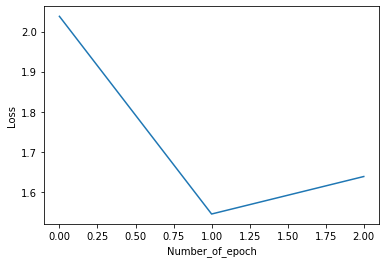

In [93]:
import matplotlib.pyplot as plt
plt.xlabel('Number_of_epoch')
plt.ylabel('Loss')
plt.plot(loss_box)
plt.show()

/opt/anaconda3/lib/python3.7/site-packages/ipykernel_launcher.py:13: DeprecationWarning: elementwise comparison failed; this will raise an error in the future.
  del sys.path[0]


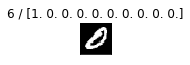

In [94]:
"""
語分類結果を並べて表示する。画像の上の表示は「推定結果/正解」である。

Parameters:
----------
y_pred : 推定値のndarray (n_samples,)
y_val : 検証データの正解ラベル(n_samples,)
X_val : 検証データの特徴量（n_samples, n_features)
"""
import numpy as np
import matplotlib.pyplot as plt
num = 36 # いくつ表示するか
true_false = y_pred==y_val.argmax(1)
false_list = np.where(true_false==False)[0].astype(np.int)
if false_list.shape[0] < num:
    num = false_list.shape[0]
fig = plt.figure(figsize=(6, 6))
fig.subplots_adjust(left=0, right=0.8,  bottom=0, top=0.8, hspace=1, wspace=0.5)
for i in range(num):
    ax = fig.add_subplot(6, 6, i + 1, xticks=[], yticks=[])
    ax.set_title("{} / {}".format(y_pred[false_list[i]],y_val[false_list[i]]))
    ax.imshow(X_val.reshape(-1,28,28)[false_list[i]], cmap='gray')